In [2]:
import dataloader

In [3]:
sequence_length = 500
crop_end = 2
n_train = 2400
n_test = 100
n_data = sequence_length * (n_train + n_test)
input_length = 21
percept_length = 18

print 'load data ({0})...'.format(n_data)
data = dataloader.get_data(0, n_data + 1)
inputs, percepts = dataloader.make_batches(data, sequence_length, crop_end=crop_end)
x_train = inputs[:n_train]
y_train = percepts[:n_train]

x_test = inputs[n_train:]
y_test = percepts[n_train:]

load data (1250000)...


In [5]:
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print x_test[0, 1]
print '=================='
print y_test[0, 0]

(2400, 498, 21) (2400, 498, 18) (100, 498, 21) (100, 498, 18)
[ 0.          0.          0.          0.          0.          0.06222387
  0.          0.          0.          0.07757615  0.08230664  0.08631713
  0.0891002   0.09022337  0.08949184  0.08703385  0.08324369  0.07862641
  0.          1.          0.        ]
[ 0.          0.          0.          0.          0.          0.06222387
  0.          0.          0.          0.07757615  0.08230664  0.08631713
  0.0891002   0.09022337  0.08949184  0.08703385  0.08324369  0.07862641]


In [6]:
def plot_states_interleaved(actual, prediction=None, color_actual='#99ccee', color_prediction='#44ddff', errorvis=True):
    if prediction is not None:
        assert actual.shape[0] == prediction.shape[0]
    n_steps = actual.shape[0]
    ylim = (0, 1)
    fig = plt.figure(figsize=(12, n_steps*2.))
    fig.suptitle('Prediction: {0}'.format(prediction is not None), fontsize=14)
    # fig.set_facecolor('#999999')
    for i in xrange(n_steps):
        ax = fig.add_subplot(n_steps, 1, i+1)
        # ax.set_axis_bgcolor('#999999')
            
        if prediction is not None:
            if errorvis:
#                 ax.bar(np.arange(prediction.shape[1])-0.5, 
#                        prediction[i], 
#                        width=0.35, 
#                        color='r', 
#                        alpha=1.0,
#                        linewidth=0, 
#                        align='center')
#                 ax.bar(np.arange(actual.shape[1])-0.5, actual[i], color=color_actual, linewidth=0, align='center')
#                 ax.bar(np.arange(prediction.shape[1])-0.5, 
#                        actual[i, :prediction.shape[1]], 
#                        width=0.35, 
#                        color='r', 
#                        alpha=1.0,
#                        linewidth=0, 
#                        align='center')
#                 ax.bar(np.arange(prediction.shape[1])-0.5, 
#                        np.minimum(actual[i, :prediction.shape[1]], prediction[i]), 
#                        width=0.35, 
#                        color='#555555', 
#                        alpha=1.0,
#                        linewidth=0, 
#                        align='center')
                ax.bar(np.arange(actual.shape[1])-0.5, actual[i], color=color_actual, linewidth=0, align='center')
                ax.bar(np.arange(prediction.shape[1])-0.5,
                       actual[i, :prediction.shape[1]] - prediction[i], 
                       bottom = prediction[i],
                       width=0.35, 
                       color='#660000', 
                       alpha=1.0,
                       linewidth=0, 
                       align='center')
                
            else:
                ax.bar(np.arange(actual.shape[1])-0.5, actual[i], color=color_actual, linewidth=0, align='center')
                ax.bar(np.arange(prediction.shape[1])-0.5, prediction[i], 
                       width=0.35, 
                       color=color_prediction, 
                       alpha=0.7,
                       linewidth=0, 
                       align='center')
        else:
            ax.bar(np.arange(actual.shape[1])-0.5, actual[i], color=color_actual, linewidth=0, align='center')
            
        ax.set_xlim(0, 20.5)
        ax.axvline(x=8.0, color='#cccccc')
        ax.axvline(x=17.0, color='#cccccc')
        ax.get_xaxis().set_visible(False)
        ax.set_ylim(ylim[0], ylim[1])

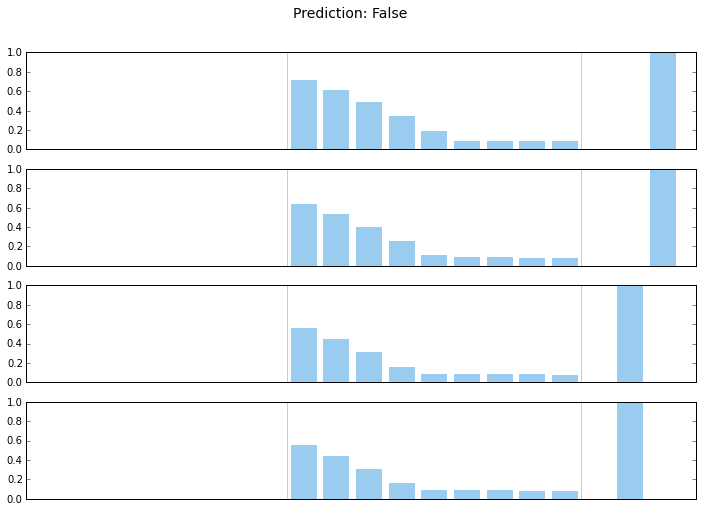

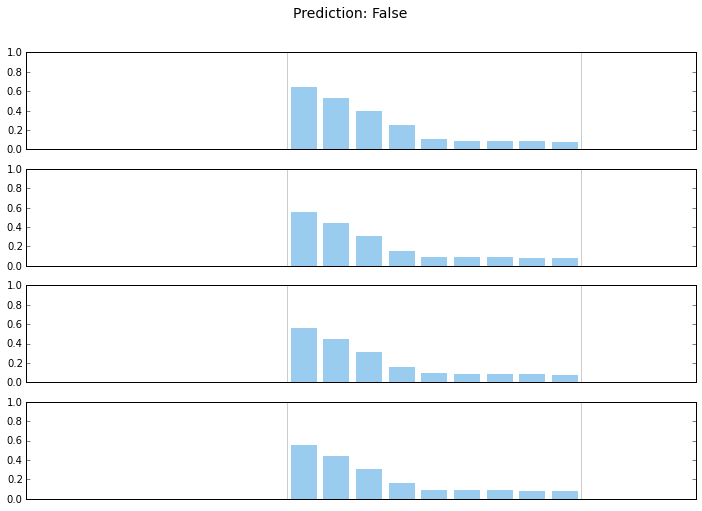

In [7]:
n_plot = 4

plot_states_interleaved(x_test[98, -n_plot:])
plot_states_interleaved(y_test[98, -n_plot:])

# print x_test[0, -1]
# print y_test[0, -2]

    
plt.show()

In [8]:
import time
from keras.models import model_from_json

In [19]:
from keras.models import Sequential
from keras.layers.core import TimeDistributedDense, Activation, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, JZS1, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop

print 'Loading and compiling model. This may take a while.'
dir_name = '20151029out_200000/'
architecture_filename = dir_name + 'json.dat'
weights_filename = dir_name + 'model_checkpoint.h5'

time.sleep(0.1)


tic = time.time()
# print 'loading model architecture...'
# model = model_from_json(open(architecture_filename).read())

model = Sequential()
model.add(LSTM(100,
               input_dim=input_length,
               return_sequences=True))
model.add(LSTM(100,
               return_sequences=True))
model.add(TimeDistributedDense(2*percept_length))
model.add(Activation('sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

print 'loading model weights...'
model.load_weights(weights_filename)
toc = time.time()
print 'loading the model took {0} seconds'.format(toc - tic)

Loading and compiling model. This may take a while.
loading model weights...
loading the model took 62.845772028 seconds


/usr/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [45]:
model.load_weights(weights_filename)

#### Performance on Training set 

In [46]:
pred_train = model.predict(x_train)
actual_train = y_train

print pred_train.shape


(2400, 498, 36)


In [47]:
print np.mean((actual_train-pred_train[:, :, :18]) ** 2)

0.00152401179094


#### Performance on Test set 

In [48]:
# score = model.evaluate(x_test, y_test, batch_size=1)
# print score

pred_and_sigmas = model.predict(x_test)
pred, sigmas= pred_and_sigmas[:, :, :18], pred_and_sigmas[:, :, 18:]

actual = y_test

n_display = 10
# for i in xrange(actual.shape[1]-n_display, actual.shape[1]):
# plot_data(pred[0, :n_display])
    
print 'MSE: {0}'.format(np.mean((y_test-pred) ** 2))
print 'Mean sigma: {0}'.format(np.mean(sigmas))

MSE: 0.00148915857603
Mean sigma: 0.0111093208551


Performance w.r.t. depth:

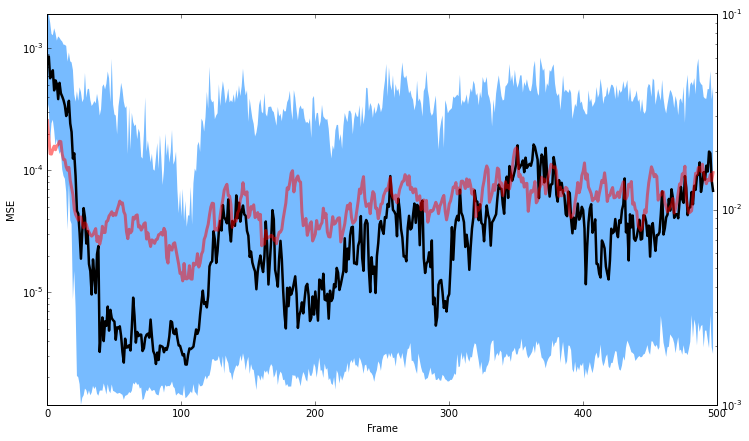

In [53]:
reduced_means_batches_times = np.mean((y_test-pred) ** 2, axis=2)

reduced_means_time_25s = np.percentile(reduced_means_batches_times, 25.0, axis=0)
reduced_means_time_medians = np.median(reduced_means_batches_times, axis=0)
reduced_means_time_75s = np.percentile(reduced_means_batches_times, 75.0, axis=0)

mean_sigmas = np.mean(np.mean(sigmas, axis=2), axis=0)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.fill_between(np.arange(y_test.shape[1]), reduced_means_time_25s, 
                reduced_means_time_75s, facecolor='#77bbff', interpolate=True, lw=0)
ax.plot(reduced_means_time_medians, color='k', lw=2.5)
ax.set_yscale('log')
ax.set_ylim(0, np.max(reduced_means_time_75s))
ax.set_xlabel('Frame')
ax.set_ylabel('MSE')

# ax2 = fig.add_subplot(212)
# ax2.plot(mean_sigmas, color='r')
ax2 = ax.twinx()
ax2.plot(mean_sigmas, color='r', alpha=0.5, lw=3)
ax2.set_yscale('log')
# ax2.set_ylabel('sin', color='r')
# for tl in ax2.get_yticklabels():
#     tl.set_color('r')

plt.show()

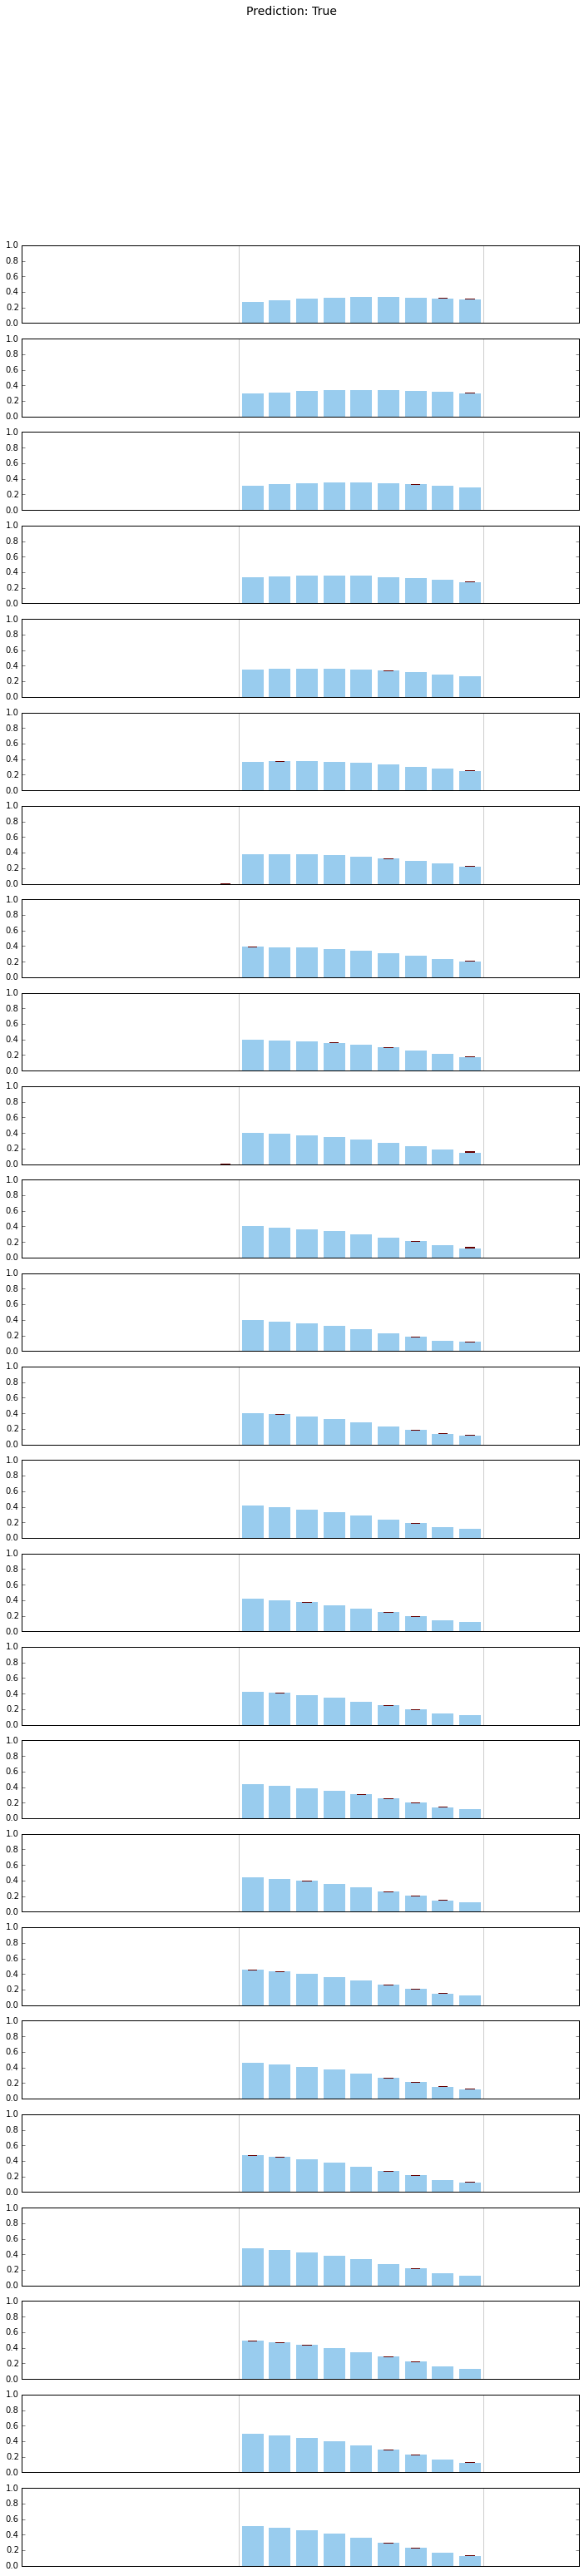

In [44]:
# Plot the n_display last images from the specified batch.
batch = 16
n_display=25
plot_states_interleaved(y_test[batch, -n_display:], pred[batch, -n_display:])

### Recursive predictions

(25, 21)
(25, 18)
(1, 50, 21)


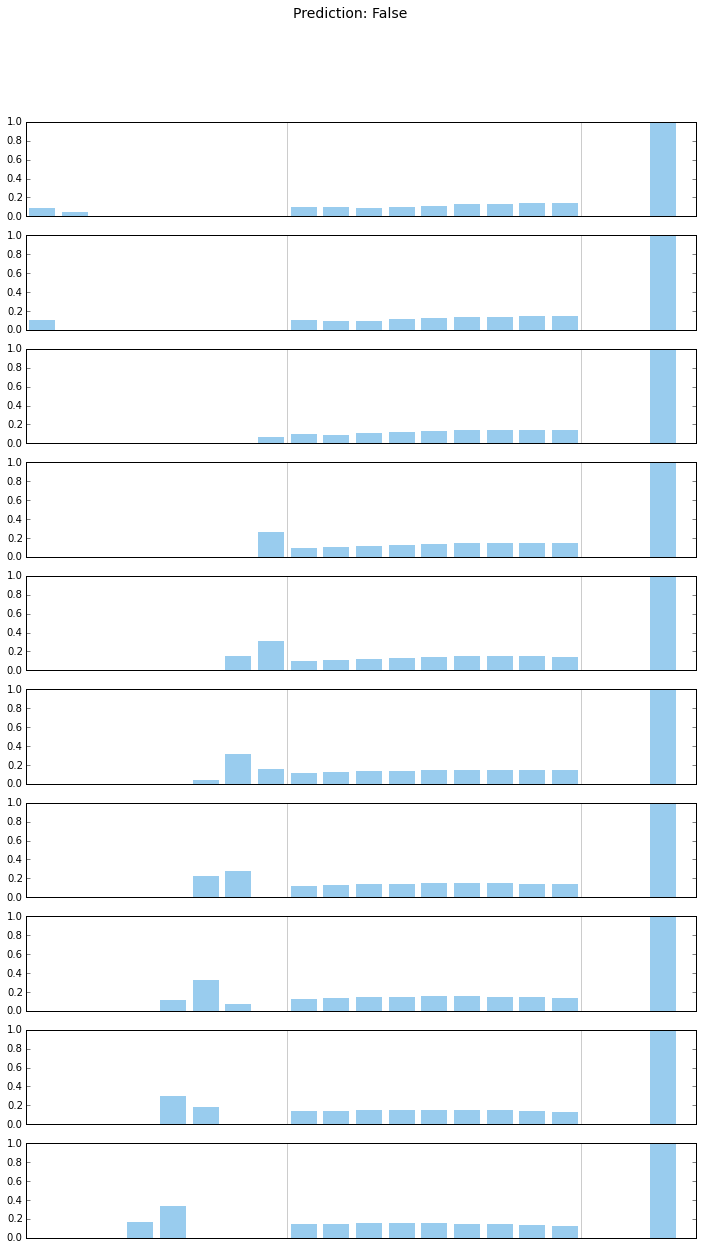

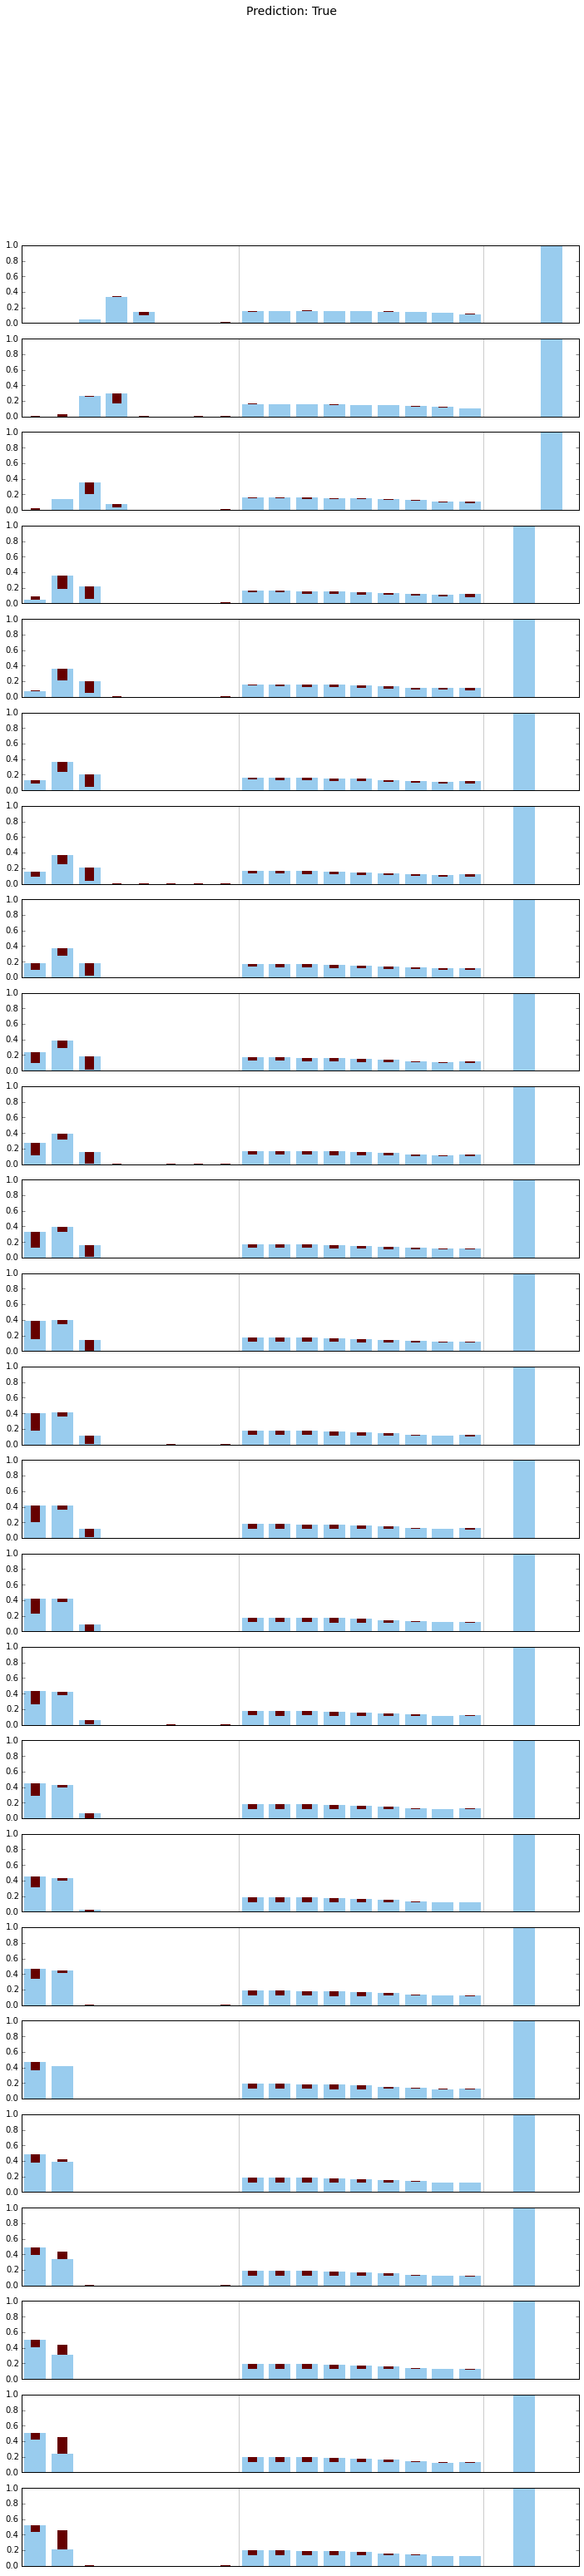

In [12]:
batch = 4
init_frames = 50
n_predict = 25
n_pre_vis = 10
past_percepts = np.array(x_test[batch: batch+1, 0:init_frames])

predictions = []
for i in xrange(n_predict):
    complete_prediction = model.predict(past_percepts)
    current_prediction = complete_prediction[0, -1]
    predictions.append(current_prediction)
    current_action = x_test[batch, init_frames+i, -3:]
    next_input = np.append(current_prediction, current_action)
    past_percepts[:-1] = past_percepts[1:]
    past_percepts[-1] = next_input


predictions = np.asarray(predictions)
actual = x_test[batch, init_frames:init_frames+n_predict]

print actual.shape
print predictions.shape
print past_percepts.shape

plot_states_interleaved(x_test[batch, init_frames-n_pre_vis: init_frames])
plot_states_interleaved(actual, predictions)

# plot_states_interleaved(x_test[batch, 245:255], y_test[batch, 244:254])


#### Evaluate recursive prediction accuracy

In [13]:
def recursive_prediction(model, past, next_actions):
    past_percepts = np.array(past)
    n_predict = next_actions.shape[0]
    
    predictions = []
    for i in xrange(n_predict):
        complete_prediction = model.predict(past_percepts)
        current_prediction = complete_prediction[0, -1]
        predictions.append(current_prediction)
        current_action = next_actions[i]
        next_input = np.append(current_prediction, current_action)
        past_percepts[:-1] = past_percepts[1:]
        past_percepts[-1] = next_input
        
    return np.array(predictions)

In [14]:
n_predict = 25
n_init = 250
errs = []
n_batches_evaluate_recursive = 2 # n_test
for batch_index in xrange(n_batches_evaluate_recursive):
    print batch_index
    for start_offset in xrange(sequence_length - n_predict - n_init - crop_end):
        pr = recursive_prediction(model=model, 
                                  past=x_test[batch_index:batch_index+1, start_offset: start_offset+n_init], 
                                  next_actions=x_test[0, start_offset+n_init: start_offset+n_init+n_predict, -3:])
        actual = x_test[batch_index, start_offset+n_init: start_offset+n_init+n_predict, :-3]
        errs.append((pr - actual) ** 2)

errs = np.asarray(errs)

0
1


In [15]:
mean_errs = np.mean(errs, axis=0)
mean_errs = np.mean(mean_errs, axis=1)


median_errs = np.median(np.mean(errs, axis=2),
                        axis=0)
errs_75 = np.percentile(np.mean(errs, axis=2), 
                        75.0, axis=0)
errs_25 = np.percentile(np.mean(errs, axis=2), 
                        25.0, axis=0)

#### Visualize recursive prediction error 

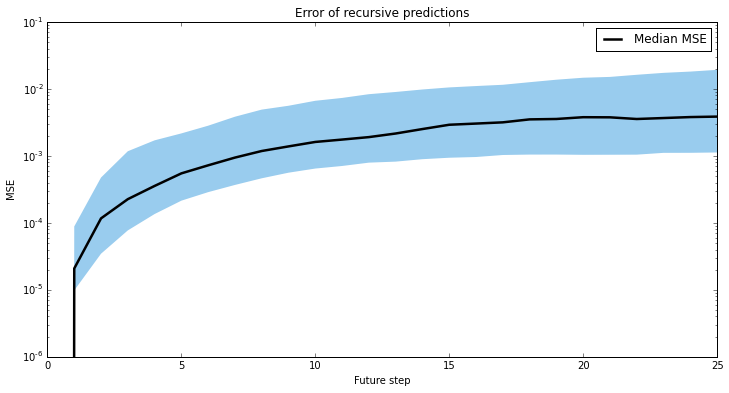

In [16]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set_ylabel('MSE')
ax.set_xlabel('Future step')
ax.set_yscale('linear')
# ax.grid()
ax.set_title('Error of recursive predictions')
# ax.plot(np.arange(1, mean_errs.shape[0] + 1), mean_errs)
ax.fill_between(np.arange(median_errs.shape[0]+1), 
                np.append([0], errs_25),
                np.append([0], errs_75),
                facecolor='#99ccee', interpolate=True, lw=0,
                label='25% -- 75%')
ax.plot(np.append([0], median_errs), color='k', lw=2.5, label='Median MSE')
yscale='log'
ax.set_yscale(yscale)
ax.legend()
fig.savefig('plots/recursive-median-{0}.png'.format(yscale))